# Social Computing/Social Gaming - Summer 2022

# Exercise Sheet 5: Clustering with WoW

In this exercise, we will take a look at Gaussian Mixture Models and apply them to data gathered from the MMO-RPG *World of Warcraft* in order to predict Bartle's playertypes.

## Task 5.0: The Data

Below, you will find an explanation of the dataset we are going to use. 

The World of Warcraft Avatar History dataset [1] contains records of players with information about their character, location and a timestamp.

The dataset has seven columns:
- **char**: an ID for each character
- **level**: the level of the character
- **race**: the race of the character
- **charclass**: the class of the character
- **zone**: the area/zone the character was at when the data was gathered
- **guild**: the numeric ID of a guild, if the character is not a member of a guild the value is `-1`
- **timestamp**: a timestamp of the moment the data was gathered. The timestamp is of the format `MM/DD/YY/Hour/Minute/Second`

For our analysis we are only going to use `char`, `zone` and `timestamp`. With this information we will be able to cluster the players playtime by each zone and to assign them to one of Bartle's playertypes.

We will define the four playertypes as follows:
- **killer**: players with the highest playtime in the PvP (Player vs Player) maps
- **socializer**: players with the highest playtime in cities, where they can easily interact and chat with other players, or the arenas
- **explorer**: players with quite high playtimes in areal zones and high time in dungeons (exploring the map and dungeons)
- **achiever**: players with high playtimes in areal zones and quite high time in dungeons (leveling and grinding new/better gear)

Since the dataset contains quite a lot of entries and players, we will only focus on players from the largest guild (ID: `103`).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Task 5.1: Preparation

Now that you are armed with all the knowledge needed, let us begin. 

**a)** First, **read** the `wowah_data.csv` and `zones.csv` that you downloaded with this exercise into seperate dataframes.

We will gather all types of zones and assign them to one of the four following categories:
- **0** (social): cities and arenas
- **1** (zones): all zones, transists, seas and event areas
- **2** (dungeons): all dungeons
- **3** (battlegrounds): all PvP zones

**b)** After all zone types where assigned their new values, replace the zones from `data` with the new labels in the `zone_list`.

*Hint: Use the `DataFrame.replace` function from pandas for b)*

In [2]:
# DONE 1: read the .csv files
data = pd.read_csv("wowah_data.csv")
zones = pd.read_csv("zones.csv")

# only use players from the largest guild
data = data[data[" guild"] == 103]

# get a list of all columns in the dataset zones
zones_columns = list(zones.columns)
zones_columns.remove("Zone_Name")
zones_columns.remove("Type")

# drop all columns except for 'Zone_Name' and 'Type'
zones = zones.drop(zones_columns, axis=1)

# group the zones into the four groups of zones
zone_list = [("Shattrath City", 0), ("Silvermoon City", 0), ("Stormwind City", 0), ("Blade's Edge Arena", 0),
             ("Searing Gorge", 1), ("The Veiled Sea", 1), ("The Great Sea", 1),
             ("The North Sea", 1), ("The Frozen Sea", 1)]

type_list = [("City", 0), ("Arena", 0),
             ("Event", 1), ("Transit", 1), ("Sea", 1), ("Zone", 1),
             ("Dungeon", 2),
             ("Battleground", 3)]

for t, new_t in type_list:
    zones = zones.replace(t, new_t, regex=True)

for row in zones.itertuples():
    zone_list.append(tuple([elem for elem in row[1:]]))

    
# DONE 2: rename the zones in the main dataframe
for zone, label in zone_list:
    if isinstance(zone, str):# I had to check if the zone was not a number, otherwise the zones 0 would have been replaced by 1
        data[" zone"].replace(to_replace = zone, value = label, inplace = True)

# take a look at the data

print(data.head(10))

     char   level    race  charclass  zone   guild          timestamp
9   23062      69     Orc     Shaman     0     103  01/01/08 00:02:14
23  22557      70     Orc     Hunter     0     103  01/01/08 00:02:24
31  23186      70     Orc     Hunter     0     103  01/01/08 00:02:24
33  15605      70     Orc     Hunter     0     103  01/01/08 00:02:24
34  64510      70     Orc     Hunter     3     103  01/01/08 00:02:24
39  61421      70     Orc      Rogue     3     103  01/01/08 00:02:29
40  57137      70     Orc      Rogue     3     103  01/01/08 00:02:29
76   1316      70  Tauren    Warrior     2     103  01/01/08 00:02:59
80  23577      70  Tauren    Warrior     1     103  01/01/08 00:02:59
82  22071      70  Tauren    Warrior     3     103  01/01/08 00:02:59


We will now split the timestamp into the date and the actual time and drop some unnecessary columns from the dataset.

In [3]:
# get all timestamps
timestamps = data[" timestamp"]
hours, minutes = [], []
dates = []

# split the timestamp into date and time
# and split time into hour and minute
for timestamp in timestamps:
    date, time = timestamp.split(" ")
    
    hour, minute, second = time.split(":")
    
    dates.append(date)
    hours.append(hour)
    minutes.append(minute)

# append the new data to the dataset
data["date"] = dates
data["hour"] = hours
data["minute"] = minutes

# drop unneeded columns from the dataset
data = data.drop([" timestamp", " guild", " race", " level", " charclass"], axis=1)

data.to_csv(r"wowah_data_preprocessed.csv")

data.head(10)

,char,zone,date,hour,minute
9,23062,0,01/01/08,00,02
23,22557,0,01/01/08,00,02
31,23186,0,01/01/08,00,02
33,15605,0,01/01/08,00,02
34,64510,3,01/01/08,00,02
39,61421,3,01/01/08,00,02
40,57137,3,01/01/08,00,02
76,1316,2,01/01/08,00,02
80,23577,1,01/01/08,00,02
82,22071,3,01/01/08,00,02


In [4]:
data = pd.read_csv(r"wowah_data_preprocessed.csv")
data = data.drop(["Unnamed: 0"], axis=1)

data.head(10)

,char,zone,date,hour,minute
0,23062,0,01/01/08,0,2
1,22557,0,01/01/08,0,2
2,23186,0,01/01/08,0,2
3,15605,0,01/01/08,0,2
4,64510,3,01/01/08,0,2
5,61421,3,01/01/08,0,2
6,57137,3,01/01/08,0,2
7,1316,2,01/01/08,0,2
8,23577,1,01/01/08,0,2
9,22071,3,01/01/08,0,2


In [5]:
chars = []

# get all character IDs from the dataset
for row in data.itertuples():
    if row.char not in chars:
        chars.append(row.char)
       
print(len(chars))

1073


Now we will create a new dataframe for the playtimes by zones.

The total playing time per character is calculated as follows:
- We assume each player only plays until midnight
- If the difference between two timestamps is greater than one hour, we assume that this did not occure during the same session

**c)** Compute the difference between two following timestamps and save the playtime in the dictionary `zones_playtime` and add it to `total_playtime`.

After calculating the playingtime by zones for each player we want to add the relative playingtimes by zone to our new dataframe. This is necessary, since different players might have invested quite a different amount of time into this game.

In [ ]:
# create a new dataframe
df = pd.DataFrame()

# create a dictionary for playtimes by zones
playtimes_by_zones = {}

# add the character IDs
#df["char"] = chars

# assign each zone a list for playtimes
for zone in data[" zone"]:
    playtimes_by_zones[zone] = []

# for each character compute the playtime by zones
for char in chars:
    # get the data for each character
    char_data = data[data["char"] == char]
    
    # create a dictionary for playtime by zone
    zones_playtime = {zone: 0 for zone in data[" zone"]}
    total_playtime = 0

    # zip and iterate over all rows to compute time-difference
    for current_row, next_row in zip(list(char_data.itertuples()), list(char_data.itertuples())[1:]):
        # get the current timestamp
        current_zone, current_date, current_hour, current_minute = current_row[2], current_row[3], int(current_row[4]), int(current_row[5])
        
        # get the next timestamp
        next_date, next_hour, next_minute = next_row[3], int(next_row[4]), int(next_row[5])
        
        current_time_in_minutes = current_hour * 60 + current_minute
        next_time_in_minutes = next_hour * 60 + next_minute
        
        # DONE: calculate the difference between current_time_in_minutes and next_time_in_minutes
        difference = current_time_in_minutes - next_time_in_minutes
        zones_playtime[current_zone] = zones_playtime[current_zone] + current_time_in_minutes
        
    total_playtime = total_playtime + sum(zones_playtime.values()) # I couldn't test to see if total_playtime and zones_playtime
                                                                   # are right, but total_playtime should be alright
    # compute for each zone the relative playtime
    for zone in zones_playtime:
        # if total_playtime > 0 get the playtime
        if total_playtime != 0:
            relative_playtime = zones_playtime[zone] / total_playtime
        
            playtimes_by_zones[zone].append(relative_playtime)
            
        # else append 0
        else:
            playtimes_by_zones[zone].append(0)
# add the new data to the dataframe       
for zone in playtimes_by_zones:
    df[zone] = playtimes_by_zones[zone]

df[0] = playtimes_by_zones[0]
df[1] = playtimes_by_zones[1]
df[2] = playtimes_by_zones[2]
df[3] = playtimes_by_zones[3]

We will now have to remove some unwanted data.
First we will remove all rows of players with a total playingtime of 0. After that we will remove players who have a relative playtime of more than 80% in the zone type `1` (zones).

In [7]:
# remove all rows, where total_playtime is 0
df = df.loc[~(df==0).all(axis=1)]

# remove all rows where the relative playtime in zones is greater than 80%
df = df[df[1]<=0.8]

for row in df.itertuples():    
    if 0 == row[1] and row[1] == row[2] and row[2] == row[3] and row[3] == row[4]:
        print(row)
        
print(len(df[0]))
print(min(df[0]), min(df[1]), min(df[2]), min(df[3]))
    
df.head(10)

KeyError: 1

## Task 5.2: Clustering

**a) k-Means** Cluster the dataset with the k-Means algorithm and print out the centroids.

**Hint:** For the clustering we will use the k-means algorithm provided by the scikit-learn library. Import the algorithm and use the `fit()` function to let the algorithm do its work. Remember to set the amount of clusters to 4. 

In [8]:
from sklearn.cluster import KMeans

# DONE: implement the clustering with k-means
n_clusters = 4
kmeans = KMeans(n_clusters = n_clusters).fit(df)

**b) Gaussian Mixture Model** Cluster the dataset using `GaussianMixture` from `sklearn.mixture`. Again we want to an end result of 4 clusters.

**Hint:** In order to retrieve the labels, we have to use the `predict()` function. Save the labels at `gmm_labels`.

In [16]:
from sklearn.mixture import GaussianMixture

# DONE: implement the clustering with Gaussian Mixture Model
gm = GaussianMixture(n_components = n_clusters).fit(df)
gmm_labels = gm.predict(df)

**c) DBSCAN** Cluster the dataset using `DBSCAN`. 

Before we can cluster with DBSCAN, we have to identify the correct parameters for the algorithm. We can find the optimal epsilon value by plotting the distances between the datapoints and taking the value at the point of highest curvature [2].

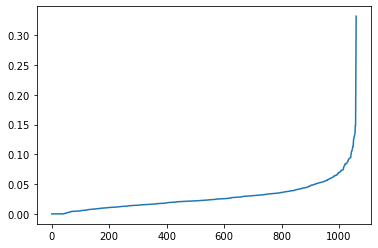

In [10]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

nn = NearestNeighbors(n_neighbors=5).fit(df)
distances, indices = nn.kneighbors(df)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

As we can see this point is roughly at 0.05, hence our epsilon will be set to 0.05. For `min_samples` we will take 2\*4, the dimension of our data.

In [11]:
# DONE: implement the clustering with dbscan
dbscan = DBSCAN(eps = 0.05, min_samples = 2*n_clusters).fit(df)

## Task 5.3: Analysis

In the next part we are going to analyze our clustering results. For this we will calculate the means of each cluster in our Gaussian Mixture Model and map the clusters using t-SNE.

**a) Means**
Before we visualize our data, we want to check if our clusters make sense. In order to do so, we can compute the means of our gmm clusters. This will also help us to identify the groups of player types later on. Write down your observations and try to map the clusters to the player types.

In [17]:
cluster0, cluster1, cluster2, cluster3 = [], [], [], []

    
for i, row in enumerate(df.itertuples()):
    row = [elem for elem in row[1:]]
    
    if gmm_labels[i] == 0:
        cluster0.append(row)
    elif gmm_labels[i] == 1:
        cluster1.append(row)
    elif gmm_labels[i] == 2:
        cluster2.append(row)
    elif gmm_labels[i] == 3:
        cluster3.append(row)
        
def get_means(cluster):
    # DONE: calculate and print the means for the given cluster
    gmm = GaussianMixture(n_components = n_clusters).fit(cluster)
    return gmm.means_

get_means(cluster0)
get_means(cluster1)
get_means(cluster2)
get_means(cluster3)

array([[3.36429686e-01, 1.06345242e-04, 1.52255976e-01, 5.11198711e-01,
        9.18059745e-06, 1.01457054e-07],
       [8.36215238e-02, 5.16161138e-05, 2.71205295e-02, 8.89180481e-01,
        1.28536949e-05, 1.29960631e-05],
       [1.95604180e-01, 4.59524706e-04, 5.83555418e-01, 2.20329376e-01,
        5.09312221e-05, 5.70049439e-07],
       [1.27454673e-01, 4.47099084e-04, 3.57041323e-01, 5.15005995e-01,
        4.18946754e-05, 9.01550416e-06]])

Based on the code, we can see that each cluster is related to the number of the zone. For example, cluster0 and the means represents the players that often spend more time in regions such as cities (label 0).

### **b)** t-SNE 

Since we used 4 features for clustering our data lies in a 4-dimensional space. Visualizing and interpreting a 4-dimensional space can be tricky, therefore, we introduce an algorithm called [t-SNE] http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) [3] that can transform a high dimensional dataset into a 2 dimensional plot. For more information you can check out the linked paper. For a simple but intuitive explanation have a look at [this video](https://www.youtube.com/watch?v=NEaUSP4YerM) [4]. 

**1.** **Run the given code to generate a t-SNE graph**. Look at the plot and choose **one** cluster from the k-means visualization which you want to analyze. Can you tell what kind of player type the cluster represents in Bartle's model? Can you explain the meaning of the distance between the clusters? 

**2.** Compare the different clusterings and try to find similarities and differences. What could be reasons for these?

**Hint**: You can see the assigned clusters for each player with the list `kmeans.labels_` and `dbscan.lbabels_`


**Note:** If you get the impression that the clustering is not very accurate do not feel discouraged as the data set does not contain enough information about the other activities of the players besides ship killing. 

C:\Users\usertest\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\usertest\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


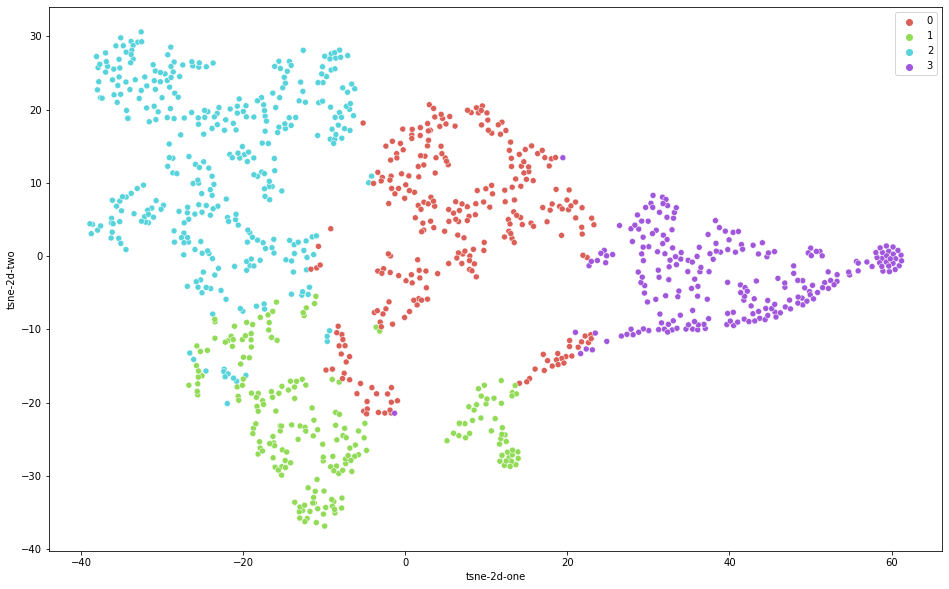

In [13]:
from sklearn.manifold import TSNE
import seaborn as sns
# t-SNE Graph
def tsne(tempData):
    tsne = TSNE(n_components=2, random_state=0)
    X_2d = tsne.fit_transform(tempData)

    new = tempData.copy()
    new['tsne-2d-one'] = X_2d[:,0]
    new['tsne-2d-two'] = X_2d[:,1]

    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x = "tsne-2d-one", y = "tsne-2d-two",
        hue = kmeans.labels_,
        palette = sns.color_palette("hls", n_clusters),
        data = new,
        legend = "full"
    )

tempData = df
tsne(tempData)

C:\Users\usertest\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\usertest\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


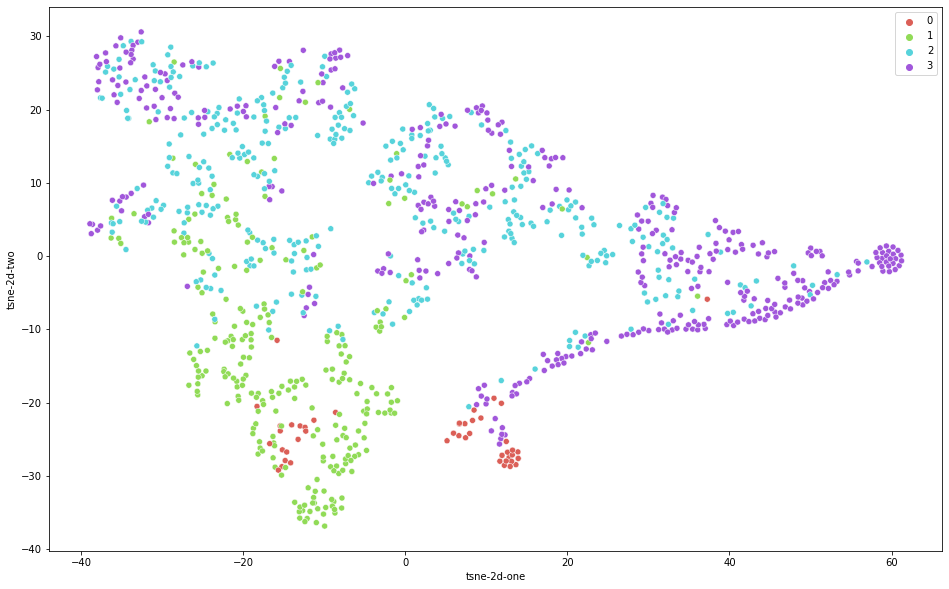

In [18]:
# t-SNE Graph
def tsne(tempData):
    tsne = TSNE(n_components=2, random_state=0)
    X_2d = tsne.fit_transform(tempData)

    new = tempData.copy()
    new['tsne-2d-one'] = X_2d[:,0]
    new['tsne-2d-two'] = X_2d[:,1]

    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x = "tsne-2d-one", y = "tsne-2d-two",
        hue = gmm_labels,
        palette = sns.color_palette("hls", n_clusters),
        data = new,
        legend = "full"
    )

tempData = df
tsne(tempData)

In [19]:
# t-SNE Graph
def tsne(tempData):
    tsne = TSNE(n_components=2, random_state=0)
    X_2d = tsne.fit_transform(tempData)

    new = tempData.copy()
    new['tsne-2d-one'] = X_2d[:,0]
    new['tsne-2d-two'] = X_2d[:,1]

    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x = "tsne-2d-one", y = "tsne-2d-two",
        hue = dbscan.labels_,
        palette = sns.color_palette("hls", 4),
        data = new,
        legend = "full"
    )
    
tempData = df
tsne(tempData)

C:\Users\usertest\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\usertest\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


ValueError: The palette list has the wrong number of colors.

<Figure size 1152x720 with 0 Axes>

Taking a look in the first graph, we can see the clustering of players based on the regions that they spent more time in. When analysing for example the region 0, we can see that it is a very central region among the other regions. That meens that even the players that often go to this region, they are also in between other regions as well. A red dot in the lower part of the graph shows a player that although goes in the majority of time to cities, also goes to region 1.

## References

[1] https://www.kaggle.com/mylesoneill/warcraft-avatar-history?select=wowah_data.csv
<br>[2] https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc
<br>[3] http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf
<br>[4] https://www.youtube.com/watch?v=NEaUSP4YerM